In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Add, Activation
from tensorflow.keras.layers import Input, ReLU, Softmax, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import tensorflow.keras as keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import SGD
from IPython.display import clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


**Cargamos el nuevo dataset**

In [2]:
data = pd.read_csv("./ds_depurado_mit_bih.csv", header=None)

In [3]:
# Separar las características (X) y las etiquetas (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [4]:
clases_train = np.bincount(y_train)
print("Número de registros de cada clase en el conjunto de entrenamiento:")
print(f"Clase 0 : {clases_train[0]}")
print(f"Clase 1 : {clases_train[1]}")
print(f"Clase 2 : {clases_train[2]}")
print(f"Clase 3 : {clases_train[3]}")
print(f"Clase 4 : {clases_train[4]}")

Número de registros de cada clase en el conjunto de entrenamiento:
Clase 0 : 69465
Clase 1 : 2140
Clase 2 : 5588
Clase 3 : 627
Clase 4 : 6144


**Balancea las 5 clases**

In [5]:
train_data_new = data;

In [6]:

from sklearn.utils import resample

# Separar las clases
class_0 = train_data_new[train_data_new.iloc[:, -1] == 0]
class_1 = train_data_new[train_data_new.iloc[:, -1] == 1]
class_2 = train_data_new[train_data_new.iloc[:, -1] == 2]
class_3 = train_data_new[train_data_new.iloc[:, -1] == 3]
class_4 = train_data_new[train_data_new.iloc[:, -1] == 4]


# Realizar oversampling de las clases minoritarias
class_1_oversampled = resample(class_1, replace=True, n_samples=int(len(class_0) * 0.22), random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=int(len(class_0) * 0.22), random_state=42)
class_3_oversampled = resample(class_3, replace=True, n_samples=int(len(class_0) * 0.22), random_state=42)
class_4_oversampled = resample(class_4, replace=True, n_samples=int(len(class_0) * 0.22), random_state=42)

# Realizar undersampling de la clase mayoritaria
class_0_undersampled = resample(class_0, replace=False, n_samples=int(len(class_0) * 0.22), random_state=42)

# Combinar las clases balanceadas
train_data_balanced = pd.concat([class_0_undersampled, class_1_oversampled, class_2_oversampled, class_3_oversampled, class_4_oversampled])

# Mezclar los datos
train_data_balanced = train_data_balanced.sample(frac=1).reset_index(drop=True)


In [7]:
X_train = train_data_balanced.iloc[:, :-1]
y_train = train_data_balanced.iloc[:, -1]

clases_train = np.bincount(y_train)
print("Número de registros de cada clase en el conjunto de entrenamiento:")
print(f"Clase 0 : {clases_train[0]}")
print(f"Clase 1 : {clases_train[1]}")
print(f"Clase 2 : {clases_train[2]}")
print(f"Clase 3 : {clases_train[3]}")
print(f"Clase 4 : {clases_train[4]}")

Número de registros de cada clase en el conjunto de entrenamiento:
Clase 0 : 19106
Clase 1 : 19106
Clase 2 : 19106
Clase 3 : 19106
Clase 4 : 19106


**Separamos train y test**

In [8]:
# Separar las características (X) y las etiquetas (y)
X = train_data_balanced.iloc[:, :-1]
y = train_data_balanced.iloc[:, -1]

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#se separan las características (X) y las etiquetas (Y)
# Separar las características (X) y las etiquetas (y) en cada DataFrame
#X_train = train_data_new.iloc[:, :-1]
#y_train = train_data_new.iloc[:, -1]
#X_test = test_data_new.iloc[:, :-1]
#y_test = test_data_new.iloc[:, -1]

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (76424, 187)
y_train: (76424,)
X_test: (19106, 187)
y_test: (19106,)


In [10]:
X_train.shape

(76424, 187)

In [11]:
X_test.shape

(19106, 187)

In [12]:
#funcion de visualizacion
def visualizacion_resultados(history, epochs,y1_min, y1_max, y2_min,y2_max):
    epochs = [i for i in range(epochs)]
    fig, ax = plt.subplots(1,2)
    train_acc = history.history["accuracy"]
    train_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]
    fig.set_size_inches(16,9)
    
    ax[0].plot(epochs, train_acc, "go-", label = "Entrenamiento accuracy")
    ax[0].plot(epochs, val_acc, "ro-", label = "Validación accuracy")
    ax[0].set_title("Entrenamiento & validación accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_ylim(y1_min, y1_max)
    
    ax[1].plot(epochs, train_loss, "go-", label = "Entrenamiento loss")
    ax[1].plot(epochs, val_loss, "ro-", label = "Validación loss")
    ax[1].set_title("Entrenamiento & validación loss")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].set_ylim(y2_min, y2_max)
    
    plt.show()
    

**Inicia proceso para Keras Tunner**

In [13]:
from tensorflow.keras import regularizers

l2_regularizer = regularizers.L2(l2=1e-5)


In [14]:
import keras_tuner as kt
from tensorflow import keras

In [15]:
def constructor_modelo_opt():
    model = Sequential()
    
    model.add(Conv1D(128, 
                     kernel_size=4, 
                     padding='same', 
                     input_shape=(187,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4,
                          strides=2))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(256, 
                     kernel_size=4, 
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4,
                          strides=2))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(416,
                    kernel_regularizer= l2_regularizer,
                    activation="relu"))
    model.add(Dropout(0.5))    
    
    model.add(Dense(128,
                    kernel_regularizer= l2_regularizer,
                    activation="relu"))
    model.add(Dropout(0.3))  
    model.add(Dense(64,
                    kernel_regularizer= l2_regularizer,
                    activation="relu"))
    model.add(Dropout(0.2))  
    model.add(Dense(5, activation="softmax"))
    
    model.compile(
        optimizer= tf.keras.optimizers.legacy.Adam(0.001),
        loss= "sparse_categorical_crossentropy",
        metrics=["accuracy"]  
    )
    
    return model



In [16]:
modelo_opt = constructor_modelo_opt()

Metal device set to: Apple M1 Pro


In [17]:
from tensorflow.keras.callbacks import TensorBoard
from time import time

In [18]:
model_tensorboard = modelo_opt

In [19]:
model_tensorboard.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
callback_tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [21]:
callback_early = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    mode="auto"
)

In [22]:
history_tensor = modelo_opt.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[callback_tensorboard, callback_early]
)

Epoch 1/30


2023-05-07 11:28:50.784890: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2389/2389 [==============================] - 65s 27ms/step - loss: 0.8246 - accuracy: 0.7321 - val_loss: 0.4697 - val_accuracy: 0.8455
Epoch 2/30
2389/2389 [==============================] - 65s 27ms/step - loss: 0.3917 - accuracy: 0.8702 - val_loss: 0.3423 - val_accuracy: 0.8871
Epoch 3/30
2389/2389 [==============================] - 66s 27ms/step - loss: 0.3140 - accuracy: 0.9080 - val_loss: 0.2947 - val_accuracy: 0.9222
Epoch 4/30
2389/2389 [==============================] - 66s 28ms/step - loss: 0.2856 - accuracy: 0.9264 - val_loss: 0.2921 - val_accuracy: 0.9421
Epoch 5/30
2389/2389 [==============================] - 66s 28ms/step - loss: 0.2703 - accuracy: 0.9354 - val_loss: 0.4738 - val_accuracy: 0.8494
Epoch 6/30
2389/2389 [==============================] - 66s 28ms/step - loss: 0.2506 - accuracy: 0.9442 - val_loss: 0.2305 - val_accuracy: 0.9544
Epoch 7/30
2389/2389 [==============================] - 66s 28ms/step - loss: 0.2389 - accuracy: 0.9495 - val_loss: 0.2095 - val_accura

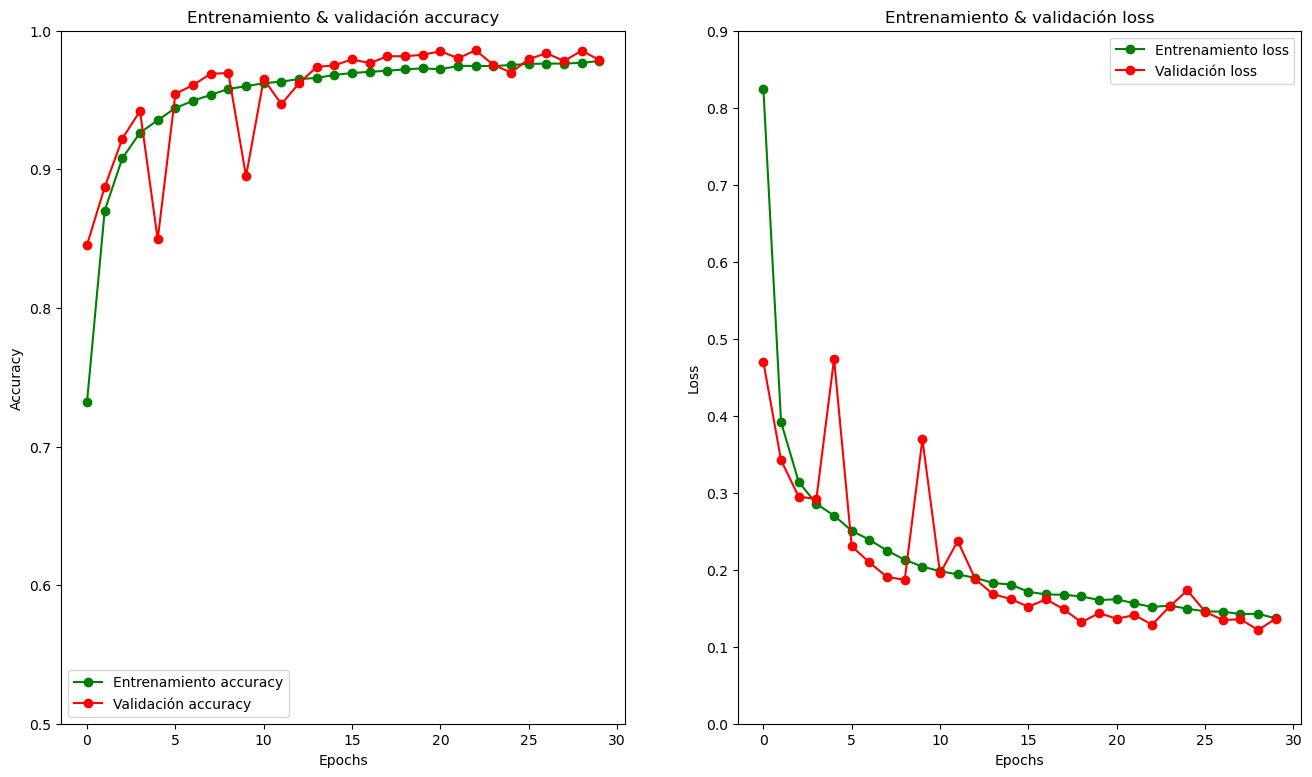

In [23]:
visualizacion_resultados(history_tensor, 30, 0.5,1, 0,0.9)

In [25]:
import seaborn as sns

def resultados():
    # Graficar la pérdida y precisión durante el entrenamiento y validación
    plt.figure(figsize=(12, 4))


    # Predecir las etiquetas en el conjunto de prueba
    y_pred = model_tensorboard.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)


    # Calcular y mostrar métricas de rendimiento
    c = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(c, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Clase predicha')
    plt.ylabel('Clase real')
    plt.title('Matriz de confusión')
    plt.show()

    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred_classes))


598/598 [==============================] - 3s 6ms/step


<Figure size 1200x400 with 0 Axes>

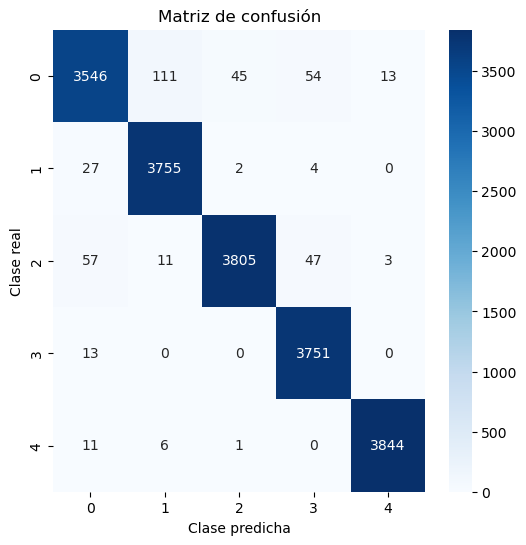


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3769
           1       0.97      0.99      0.98      3788
           2       0.99      0.97      0.98      3923
           3       0.97      1.00      0.98      3764
           4       1.00      1.00      1.00      3862

    accuracy                           0.98     19106
   macro avg       0.98      0.98      0.98     19106
weighted avg       0.98      0.98      0.98     19106



In [26]:
resultados()

In [27]:
model_tensorboard.evaluate(X_test, y_test)

598/598 [==============================] - 9s 14ms/step - loss: 0.1365 - accuracy: 0.9788


[0.13652119040489197, 0.9788024425506592]

In [ ]:
model_tensorboard.save('clasificador_ver5.h5')